# Adversarial examples for signatures - example

This notebook shows a case of adversarial examples for handwritten signatures (https://github.com/luizgh/adversarial_signatures). The following steps are considered:

1. Load data
2. Extract features and train a WD classifier
3. Perform a type-I attack (change a genuine signature so that it is rejected)
4. Perform a type-II attack (change a skilled forgery so that it is accepted)

For more details, refer to the paper:

[1] Hafemann, Luiz G., Robert Sabourin, and Luiz S. Oliveira. "Characterizing and evaluating adversarial examples for Offline Handwritten Signature Verification" [preprint](https://arxiv.org/abs/1901.03398)

In [1]:
# Load the required libraries:

import torch
import numpy as np
import matplotlib.pyplot as plt

# Model and WD training:
from sigver.featurelearning.models import SigNet
from wd import create_trainset_for_user, train_wdclassifier_user

# Functions to generate attacks
from model_utils import TorchRBFSVM, ToTwoOutputs
from attacks.fgm import fgm
from attack_utils import carlini_attack, rmse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

## 1) Loading the data

We will attack signatures from a fictious user "Joao". We will also use features from other users in the MCYT dataset as negative examples (random forgeries)

Manually download these files:

Store these on adversarial_examples/data:

https://drive.google.com/open?id=1MPNJVVQXZwz38dmeqIeyditIUxTpFO2d

https://drive.google.com/open?id=1r-5lnJtChaAa8R4ocE1ZyorTdTiAqlQA

Store this on adversarial_examples/models:

https://drive.google.com/open?id=1l8NFdxSvQSLb2QTv71E6bKcTgvShKPpx

In [2]:
# Download the dataset and model

from urllib import request
from pathlib import Path


if not Path('data/dataset_joao.npz').exists() or not Path('data/mcyt_train_signet_features.npz').exists():
    raise RuntimeError('Please download the dataset from the links above')
    

if not Path('models/signet.pth').exists():
    raise RuntimeError('Please download the model from the link above')

print('All downloaded')

All downloaded


In [3]:
# Load MCYT features

mcyt_data = np.load('data/mcyt_train_signet_features.npz')
mcyt_features = mcyt_data['signet_features']
mcyt_y = mcyt_data['y']
mcyt_yforg = mcyt_data['yforg']

In [4]:
# Load dataset for the user under attack
joao_data = np.load('data/dataset_joao.npz')
joao_x, joao_y, joao_yforg = joao_data['x'], joao_data['y'], joao_data['yforg']

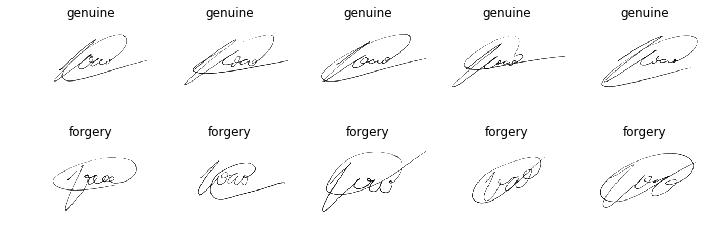

In [5]:
# Visualize some signatures
f, ax = plt.subplots(2, 5, figsize=(12, 4))
for i in range(5):
    ax[0][i].imshow(joao_x[15+i], cmap='Greys')
    ax[0][i].axis('off')
    ax[0][i].set_title('genuine' if joao_yforg[15+i] == 0 else 'forgery' )
    
for i in range(5):
    ax[1][i].imshow(joao_x[i], cmap='Greys')
    ax[1][i].axis('off')
    ax[1][i].set_title('genuine' if joao_yforg[i] == 0 else 'forgery' )

# 2) Extract features and train a WD classifier

We will use the SigNet model as a feature extractor, and an SVM with the RBF kernel as the classifier. We will consider a "Perfect Knowledge" scenario, where the attacker has full access to the system under attack.

In [6]:
# Load the trained model

state_dict, _, _  = torch.load('models/signet.pth')

model = SigNet()
model.load_state_dict(state_dict)
model = model.to(device).eval()

In [7]:
# Extract features (to train the WD classifier)
def extract_features(model, images):
    # Note: input pixels must be between [0, 1] for this model
    input = torch.tensor(images).float().div(255).view(-1, 1, 150, 220).to(device)
    with torch.no_grad():
        return model(input).cpu().numpy()
    

In [8]:
joao_features = extract_features(model, joao_x)

In [9]:
# Let's split the data into train (last 5 samples), and test. For this user, the first 15 samples
# are forgeries, and the remaining are genuine signatures
joao_train_idx = slice(20, None)
joao_test_gen_idx = slice(15, 20)
joao_test_forg_idx = slice(0, 15)

# Ensure that joao has a "y" different from all users in MCYT
assert len(set(joao_y).intersection(set(mcyt_y))) == 0

# Ensure we chose the indexes correctly: first 15 should be forgery, others should be genuine
assert np.all(joao_yforg[joao_test_gen_idx] == 0)
assert np.all(joao_yforg[joao_test_forg_idx] == 1)

joao_id = 0 

In [10]:
# Append this new user to the MCYT data:

xfeatures_train = np.concatenate((mcyt_features, joao_features[joao_train_idx]))
y_train = np.concatenate((mcyt_y, joao_y[joao_train_idx]))
yforg_train = np.concatenate((mcyt_yforg, joao_yforg[joao_train_idx]))

# Create the training set for the user
trainingSet = create_trainset_for_user(xfeatures_train, y_train, yforg_train, user=joao_id)

In [11]:
# Train the classifier
clf = train_wdclassifier_user('rbf', 1, 2**-11, trainingSet)

decision_threshold =  0.368 # From the MCYT dataset


In [12]:
# Check the predictions for unseen signatures from the user:

print('Predictions on genuine signatures (True = genuine)')
print(clf.decision_function(joao_features[joao_test_gen_idx]) > decision_threshold)
print()

print('Predictions on skilled forgeries (True = genuine)')
print(clf.decision_function(joao_features[joao_test_forg_idx]) > decision_threshold)

Predictions on genuine signatures (True = genuine)
[ True  True  True False False]

Predictions on skilled forgeries (True = genuine)
[False False False False False False False False False False False False
 False False False]


(-0.5, 219.5, 149.5, -0.5)

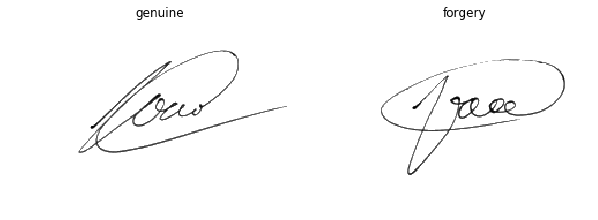

In [13]:
# Let's take the first genuine signature (id 15) and the first skilled forgery (id 0) to 
#  attack - both are correctly classified by the model

gen_idx = 15
forg_idx = 0
genuine_to_attack = joao_x[gen_idx:gen_idx+1]
forgery_to_attack = joao_x[forg_idx:forg_idx+1]

# Plot the chosen signatures
f, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(genuine_to_attack.squeeze(), cmap='Greys')
ax[0].axis('off')
ax[0].set_title('genuine')
ax[1].imshow(forgery_to_attack.squeeze(), cmap='Greys')
ax[1].set_title('forgery')
ax[1].axis('off')

# 3) Type-I attack: making a genuine signature be rejected

We will take the genuine signature above and run attacks that attempt to change it to be recognized as a forgery.

In [14]:
# First, let's concatenate the CNN model with the SVM model, so that the whole process
# is implemented in PyTorch, and we can use autograd to compute the gradients:

cnn_svm = torch.nn.Sequential(model, TorchRBFSVM(clf, device)).eval()

def to_torch(np_array):
    return torch.tensor(np_array).unsqueeze(0).float().div(255).to(device)

In [15]:
# Let's double check that the concatenated model has the same output as before:

clf_decision = clf.decision_function(joao_features[gen_idx:gen_idx+1])
cnn_svm_decision = cnn_svm(to_torch(genuine_to_attack)).item()

print('classifier score: {:.4f}; concatenated model score: {:.4f}'.format(clf_decision.item(), cnn_svm_decision))


classifier score: 0.7031; concatenated model score: 0.7031


In [16]:
# For some attacks, we need the output to be two values (prediction for class 0 and for class 1),
# We implement this in the function ToTwoOutputs, that also takes the decision threshold into consideration:
cnn_svm_two_outputs = torch.nn.Sequential(cnn_svm, ToTwoOutputs(decision_threshold)).eval()
cnn_svm_two_outputs(to_torch(genuine_to_attack))

tensor([[-0.3351,  0.3351]], device='cuda:0', grad_fn=<CatBackward>)

This is a normalized score (considering the decision threshold). If the value for class 1 (second position) is greater than 0, it means the score is greater than the decision threshold, so the signature is recognized as a genuine.

In [17]:
# Now, let's run the attacks

In [18]:
gen_fgm_atk = fgm(cnn_svm_two_outputs, genuine_to_attack, 1000, 0, device,
              image_constraints=(0, 255))


In [19]:
gen_carlini_atk = carlini_attack(cnn_svm_two_outputs, genuine_to_attack, 0, device)

In [20]:
rmse_gen_fgm = rmse(gen_fgm_atk - genuine_to_attack)
rmse_gen_carlini = rmse(gen_carlini_atk - genuine_to_attack)
score_genuine = cnn_svm_two_outputs(to_torch(genuine_to_attack))[0,1].item()
score_genuine_fgm = cnn_svm_two_outputs(to_torch(gen_fgm_atk))[0,1].item()
score_genuine_carlini = cnn_svm_two_outputs(to_torch(gen_carlini_atk))[0,1].item()

In [21]:
print('Original image score (normalized): {:.4f}'.format(score_genuine))
print('FGM attack score (normalized): {:.4f}. RMSE (distortion): {:.4f}'.format(score_genuine_fgm, rmse_gen_fgm))
print('Carlini attack score (normalized): {:.4f}. RMSE (distortion): {:.4f}'.format(score_genuine_carlini, rmse_gen_carlini))

Original image score (normalized): 0.3351
FGM attack score (normalized): -1.7107. RMSE (distortion): 5.1233
Carlini attack score (normalized): -0.5007. RMSE (distortion): 1.3703


We can see that both attacks were successful in making the signature be classified as a forgery (score < 0). Let's visualize them:

Text(0.5, 1.0, 'Carlini attack')

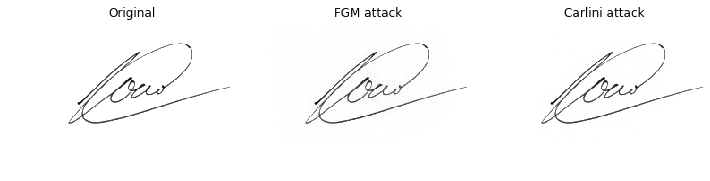

In [22]:
f, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(genuine_to_attack.squeeze(), cmap='Greys')
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(gen_fgm_atk.squeeze(), cmap='Greys')
ax[1].axis('off')
ax[1].set_title('FGM attack')

ax[2].imshow(gen_carlini_atk.squeeze(), cmap='Greys')
ax[2].axis('off')
ax[2].set_title('Carlini attack')

The two images are adversarial but we barely see any difference compared to the original

# 4) Type-II attack: making a forgery be accepted

We will take the skilled forgery above and run attacks that attempt to change it to be recognized as a genuine.

In [23]:
forg_fgm_atk = fgm(cnn_svm_two_outputs, forgery_to_attack, 1000, 1, device,
              image_constraints=(0, 255))


In [24]:
forg_carlini_atk = carlini_attack(cnn_svm_two_outputs, forgery_to_attack, 1, device)

In [25]:
rmse_forg_fgm = rmse(forg_fgm_atk - forgery_to_attack)
rmse_forg_carlini = rmse(forg_carlini_atk - forgery_to_attack)
score_forgery = cnn_svm_two_outputs(to_torch(forgery_to_attack))[0,1].item()
score_forgery_fgm = cnn_svm_two_outputs(to_torch(forg_fgm_atk))[0,1].item()
score_forgery_carlini = cnn_svm_two_outputs(to_torch(forg_carlini_atk))[0,1].item()

In [26]:
print('Original image score (normalized): {:.4f}'.format(score_forgery))
print('FGM attack score (normalized): {:.4f}. RMSE (distortion): {:.4f}'.format(score_forgery_fgm, rmse_forg_fgm))
print('Carlini attack score (normalized): {:.4f}. RMSE (distortion): {:.4f}'.format(score_forgery_carlini, rmse_forg_carlini))

Original image score (normalized): -0.1657
FGM attack score (normalized): 0.3901. RMSE (distortion): 3.3628
Carlini attack score (normalized): 0.5000. RMSE (distortion): 2.4376


Again, the two attacks were succesful (both attacks are classified as genuine)

Text(0.5, 1.0, 'Carlini attack')

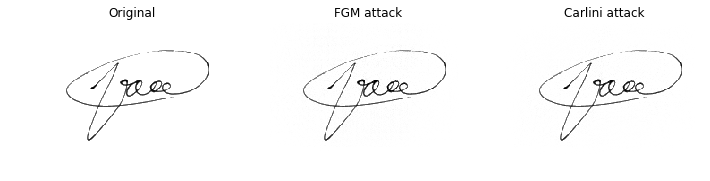

In [27]:
f, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(forgery_to_attack.squeeze(), cmap='Greys')
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(forg_fgm_atk.squeeze(), cmap='Greys')
ax[1].axis('off')
ax[1].set_title('FGM attack')

ax[2].imshow(forg_carlini_atk.squeeze(), cmap='Greys')
ax[2].axis('off')
ax[2].set_title('Carlini attack')